In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
num_inputs = 2
num_neurons = 3

In [3]:
x0 = tf.placeholder(tf.float32, [None, num_inputs])
x1 = tf.placeholder(tf.float32, [None, num_inputs])

In [5]:
Wx = tf.Variable(tf.random_normal(shape=[num_inputs, num_neurons]))

Wy =  tf.Variable(tf.random_normal([num_neurons, num_neurons]))

b=  tf.Variable(tf.zeros([1,num_neurons]))

In [6]:
y0 = tf.tanh(tf.matmul(x0, Wx)+b)

y1 = tf.tanh(tf.matmul(y0,Wy)+tf.matmul(x1, Wx)+b)


In [10]:
init = tf.global_variables_initializer()

In [11]:
x0_batch = np.array([[0,1],[2,3], [4,5]])

x1_batch = np.array([[100,101],[102,103], [104,105]])

In [13]:
with tf.Session() as sess:
    sess.run(init)
    
    y0_output, y1_output = sess.run([y0,y1],{x0:x0_batch, x1:x1_batch})

In [14]:
y0_output

array([[0.9226497 , 0.7699781 , 0.8074297 ],
       [0.9975494 , 0.9964135 , 0.51019794],
       [0.9999253 , 0.9999503 , 0.00639525]], dtype=float32)

In [15]:
y1_output

array([[ 1.,  1., -1.],
       [ 1.,  1., -1.],
       [ 1.,  1., -1.]], dtype=float32)

In [16]:
#High level API

In [19]:
class TimeSeriesData():
    
    def __init__(self, num_point, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax
        self.num_point = num_point
        self.resolution = (xmax-xmin)/num_point
        
        self.x_data = np.linspace(xmin, xmax, num_point)
        self.y_true = np.sin(self.x_data)
        
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        
        #Random starting point
        rand_start = np.random.randn(batch_size,1)
        
        #converts to be on time series
        ts_start = rand_start*(self.xmax - self.xmin - (steps*self.resolution))
        
        #create batch time series on x-axis
        batch_ts = ts_start + np.arange(0.0, steps+1)*self.resolution
        
        #create Y for that time series x 
        y_batch = np.sin(batch_ts)
        
        #formatting rnn
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)

In [20]:
ts_data = TimeSeriesData(250, 0, 10)

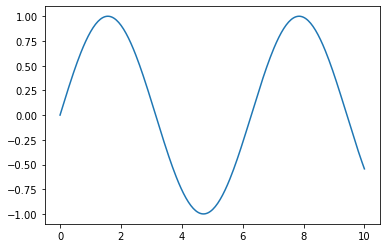

In [28]:
plt.plot(ts_data.x_data, ts_data.y_true)

In [29]:
num_time_steps = 30

In [48]:
y1, y2, ts = ts_data.next_batch(1,30,True)

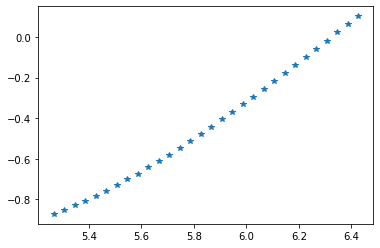

In [49]:
plt.plot(ts.flatten()[1:], y1.flatten(), '*')

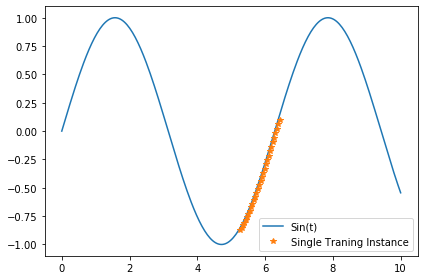

In [51]:
plt.plot(ts_data.x_data, ts_data.y_true,label = 'Sin(t)')
plt.plot(ts.flatten()[1:], y1.flatten(), '*', label = 'Single Traning Instance')
plt.legend()
plt.tight_layout()

In [53]:
#Training Data

In [54]:
train_inst = np.linspace(5 ,5 + ts_data.resolution*(num_time_steps+1), num_time_steps+1)

No handles with labels found to put in legend.


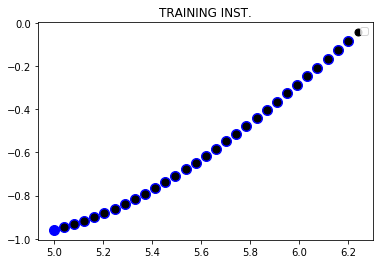

In [63]:
plt.title("TRAINING INST.")

plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo' , markersize = 10)

plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]), 'ko', markersize=7)

plt.legend()

In [62]:
#Creating Model

In [64]:
tf.reset_default_graph()

In [68]:
num_inputs = 1

num_neurons = 100

num_outputs = 1

learning_rate = 0.0001

num_train_itr = 2000

batch_size = 1

In [69]:
#Craeting Placeholders
x = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [71]:
#RNN CELL LAYER
cell = tf.contrib.rnn.BasicRNNCell(num_units = num_neurons, activation = tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_outputs)

In [72]:
output, states = tf.nn.dynamic_rnn(cell, x,dtype=tf.float32)

In [83]:
#loss
mse = tf.reduce_mean(tf.square(output-y))
opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = opt.minimize(mse)

In [84]:
init = tf.global_variables_initializer()

In [85]:
#SESSION

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction= 0.6)
saver = tf.train.Saver()

In [93]:
with tf.Session(config = tf.ConfigProto(gpu_options=gpu_options)) as sess:
    
    sess.run(init)
    
    for itr in range(num_train_itr):
        
        x_batch, y_batch = ts_data.next_batch(batch_size, num_time_steps)
        
        sess.run(train, {x:x_batch, y:y_batch})
        
        if itr %100 == 0:
            
            loss = (mse.eval(feed_dict={x:x_batch, y:y_batch}))
            print(itr, "\tMSE", loss)
            
    saver.save(sess, "./RNN_Model")

0 	MSE 0.36482462
100 	MSE 0.3465868
200 	MSE 0.008404263
300 	MSE 0.0012445678
400 	MSE 0.015790587
500 	MSE 0.011655849
600 	MSE 0.017602386
700 	MSE 0.0009060586
800 	MSE 0.004800849
900 	MSE 0.021640608
1000 	MSE 0.0123443175
1100 	MSE 0.015688011
1200 	MSE 0.00084742473
1300 	MSE 0.0017168752
1400 	MSE 0.003808825
1500 	MSE 0.0007397744
1600 	MSE 0.00051900186
1700 	MSE 0.0012783578
1800 	MSE 0.000698096
1900 	MSE 0.0023830244


In [94]:
with tf.Session() as sess:
    
    saver.restore(sess, "./RNN_Model")
    
    x_new = np.sin(np.array(train_inst[:-1]).reshape(-1, num_time_steps, num_inputs))
    
    y_pred = sess.run(output,{x:x_new})

INFO:tensorflow:Restoring parameters from ./RNN_Model


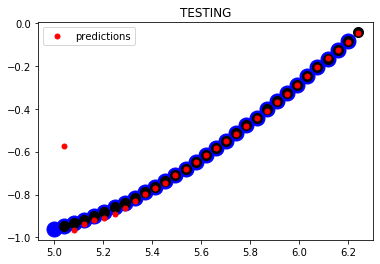

In [96]:
plt.title("TESTING")

plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), 'bo', markersize=15)

plt.plot(train_inst[1:],np.sin(train_inst[1:]),'ko',markersize=10)

plt.plot(train_inst[1:], y_pred[0,:,0],'r.', markersize=10,label='predictions')

plt.legend()

